<br>

The main goal of the project is to distinguish gamma-ray events from hadronic background events in order to identify and study celestial gamma-ray sources accurately. 


## ❗My idea
<p>Firstly, I split the most valuable feature (fAlpha) from all features in respect of Mutual Information Scores and Point-BiSerial Coefficients. Then, I applied PCA to remnant features and combined these principal components with the most valuable feature (fAlpha).<br>
As a result, this operation slightly improved the AUC ROC score.<br>
</p>

* <p><b>Mutual Information Scores</b> give information pertaining to non-linear relationships in features.</p>
* <p><b>Point-Biserial Correlation Coefficients</b> measure the association between a continuous variable and a binary variable.</p>
<br>

## Result

I used BayesSearchCV for tuning hyperparameters.

| <b>Model</b>      | <b>ROC AUC Score <span style='color:#e74c3c'></span></b> | 
| :---------------- | :----------- |
| XGBoost (Tuned)    |  0.88986    | 
| <span style='color:#e74c3c'>LightGBM</span>   |   0.89312  | 
| RBF SVM   (Tuned)   |   0.88838  |

<br>

## References
1. https://en.wikipedia.org/wiki/High_Altitude_Water_Cherenkov_Experiment
2. https://www.statisticshowto.com/point-biserial-correlation/
3. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pointbiserialr.html
4. [Use of Machine Learning for gamma/hadron separation with HAWC](https://arxiv.org/pdf/2108.00112.pdf)

In [1]:
# Importing dependencies

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions

import xgboost as xgb
import lightgbm as lgb
from skopt import BayesSearchCV


In [2]:
# Reading data and cleaning redundant columns

data = pd.read_csv('/kaggle/input/magic-telescope-dataset/MagicTelescope.csv')
data.drop(['id', 'ID'], axis=1, inplace = True)

In [3]:
# Fixing columns' name

new_col_names = []
for colname in data.columns:
    new_col_names.append(colname[:-1])

data.columns= new_col_names
data   

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g
...,...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,h
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,h
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,h
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,h


In [4]:
# Encoding classes

lb = LabelBinarizer()
data['class'] = lb.fit_transform(data['class'])
data

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,0
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,0
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,0
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,0
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,0
...,...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,1
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,1
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,1
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,1


In [5]:
# Checking missing data

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   19020 non-null  float64
 1   fWidth    19020 non-null  float64
 2   fSize     19020 non-null  float64
 3   fConc     19020 non-null  float64
 4   fConc1    19020 non-null  float64
 5   fAsym     19020 non-null  float64
 6   fM3Long   19020 non-null  float64
 7   fM3Trans  19020 non-null  float64
 8   fAlpha    19020 non-null  float64
 9   fDist     19020 non-null  float64
 10  class     19020 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 1.6 MB


In [6]:
# Scaled all features except for the class column

SC = StandardScaler()
data_scaled = data.copy()

# data_scaled.columns[:-1] or data_scaled.columns['class']
data_scaled[data_scaled.columns[:-1]] = SC.fit_transform(data_scaled[data_scaled.columns[:-1]])
data_scaled

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,-0.577226,-0.336804,-0.381130,0.062759,-0.148923,0.541042,0.224818,-0.405842,0.476816,-1.497866,0
1,-0.510969,-0.570027,-0.648595,0.820383,1.471776,0.516919,0.260364,-0.490094,-0.815418,0.153125,0
2,2.568278,6.205858,2.615783,-1.875883,-1.773241,2.044992,-1.478536,-2.183030,1.889224,0.842635,0
3,-0.694768,-0.687259,-1.029478,1.282069,1.606608,0.532771,-0.333515,-0.355359,-0.658804,-1.031463,0
4,0.516622,0.476384,0.711157,-0.347506,-0.284660,-0.020200,0.353086,1.036620,-0.881039,2.176427,0
...,...,...,...,...,...,...,...,...,...,...,...
19015,-0.752189,-0.613988,-0.442072,1.123433,1.617467,0.330947,0.019196,0.126129,-0.966282,-1.164090,1
19016,-0.573721,-0.843744,-1.180350,0.846640,0.576817,0.699497,0.051761,-0.154268,2.266097,0.717759,1
19017,0.523923,1.381779,1.318877,-1.305340,-1.445663,-0.084864,0.598262,-0.466509,0.101636,0.839003,1
19018,1.587757,2.982781,2.473375,-1.564081,-1.324404,0.171204,-2.040597,-3.077206,2.185260,2.870321,1


In [7]:
# Seperating into data features and target

X = data_scaled[data_scaled.columns[:-1]]
y = data_scaled.pop('class')

print("X shape -> ", X.shape)
print("y shape -> ", y.shape)

X shape ->  (19020, 10)
y shape ->  (19020,)


# <span style="color:#e74c3c;"> </span> Feature engineering 

In [8]:
# Calculating Point-BiSerial Coefficients (each feature vs class)

point_biserial_coefs = []

for i in range(X.shape[1]):
    coef = stats.pointbiserialr(X.iloc[:,i], y)[0]
    point_biserial_coefs.append(coef)
    
    
mutual_inf = mutual_info_classif(X,y)


feature_importance = pd.DataFrame({'Mutual Inf':mutual_inf, 'Point-BiSerial':point_biserial_coefs}, index = X.columns )
feature_importance

,Mutual Inf,Point-BiSerial
fLength,0.085561,0.307572
fWidth,0.097287,0.265596
fSize,0.054191,0.117795
fConc,0.023185,-0.024615
fConc1,0.014761,-0.004797
fAsym,0.043279,-0.173587
fM3Long,0.077938,-0.193409
fM3Trans,0.068759,0.003837
fAlpha,0.124128,0.460979
fDist,0.013011,0.065203


<p style='font-style:italic; color:#e74c3c'>It is an overt fact that there is a positive relationship between the fAlpha feature and target classes. It is an overt fact that there is a positive relationship between the fAlpha feature and target classes, both Mutual Information Score and  Point-BiSerial Coefficient.</p>

In [9]:
most_val_feature = X['fAlpha']
X = X.drop(['fAlpha'], axis=1)

In [10]:
# Appliying PCA for dimensioanilty reduction  (nearly 95% variance ratio)

PCA_ = PCA(n_components=6) 
X_pca = PCA_.fit_transform(X)

In [11]:
# Creating new feautures and concatainating with most valuable feature 

X_pca = pd.DataFrame(X_pca)
X_pca.columns = ['feature1','feature2','feature3','feature4','feature5','feature6']
X_new = pd.concat([X_pca, most_val_feature], axis=1)
X_new

,feature1,feature2,feature3,feature4,feature5,feature6,fAlpha
0,-0.976560,-0.748896,0.311115,1.231575,-0.465817,0.039070,0.476816
1,-1.769254,-0.052060,0.475255,-0.621207,0.488070,0.484020,-0.815418
2,6.205547,0.225105,1.828333,2.412718,3.429119,2.713832,1.889224
3,-2.625621,0.375962,0.282427,0.439476,0.249396,0.587025,-0.658804
4,1.568912,-0.069018,-0.947766,-1.760832,0.805299,-0.125787,-0.881039
...,...,...,...,...,...,...,...
19015,-2.288505,0.153738,-0.180653,0.368383,-0.133524,0.685441,-0.966282
19016,-1.651991,-0.168013,0.148560,-0.849865,0.791556,-0.235988,2.266097
19017,2.779167,-0.767748,0.473034,-0.128418,0.051151,0.000067,0.101636
19018,4.893484,1.244443,3.024810,-0.081467,2.833238,-0.118740,2.185260


In [12]:
# Splitting dataset for train and test

X_train, X_test, y_train, y_test = train_test_split(X_new,y, test_size = 0.25 , shuffle = True, stratify = y)

print("X_train shape -> ", X_train.shape)
print("X_test shape -> ", X_test.shape)

X_train shape ->  (14265, 7)
X_test shape ->  (4755, 7)



# <span style="color:#e74c3c;"> Model 1: </span> XGB

In [13]:
# Creating XGB model (tuned with BayesSearchCV) and fitting

model_xgb = xgb.XGBClassifier(learning_rate=0.005898149716597735, max_depth=15, n_estimators=1500)
model_xgb.fit(X_train,y_train)

y_pred = model_xgb.predict(X_test)
y_pred_prob = model_xgb.predict_proba(X_test)

roc_auc_xgb = roc_auc_score(y_test, y_pred_prob[:,1]) # for calculating we have to one class 0 or 1 
print('ROC AUC Score of XGBoost: {0:.5f}'.format(roc_auc_xgb))

ROC AUC Score of XGBoost: 0.89168



# <span style="color:#e74c3c;"> Model 2: </span> LightGBM

In [14]:
# Creating LightGBM Classifier (tuned with BayesSearchCV) and fitting

lgbm_model = lgb.LGBMClassifier()
lgbm_model.fit(X_train, y_train)

lgbm_model_pred = lgbm_model.predict(X_test)
lgbm_model_pred_prob = lgbm_model.predict_proba(X_test)

roc_auc_lgbm = roc_auc_score(y_test, lgbm_model_pred_prob[:,1]) # for calculating we have to one class 0 or 1 
print('ROC AUC Score of LightGBM: {0:.5f}'.format(roc_auc_lgbm))

ROC AUC Score of LightGBM: 0.89336


# <span style="color:#e74c3c;"> Model 3: </span> Radial basis function kernel SVM

In [15]:
# Creating RBF SVM (tuned with BayesSearchCV) and fitting

kernel_svm = SVC( kernel='rbf', C=5, probability = True)
kernel_svm.fit(X_train, y_train)

kernel_svm_pred = kernel_svm.predict(X_test)
kernel_svm_pred_prob = kernel_svm.predict_proba(X_test)

roc_auc_svm = roc_auc_score(y_test, kernel_svm_pred_prob[:,1]) # for calculating we have to one class 0 or 1 
print('ROC AUC Score of SVM: {0:.5f}'.format(roc_auc_svm))

ROC AUC Score of SVM: 0.88930


# <span style="color:#e74c3c;"> Plotting </span> ROC Curves

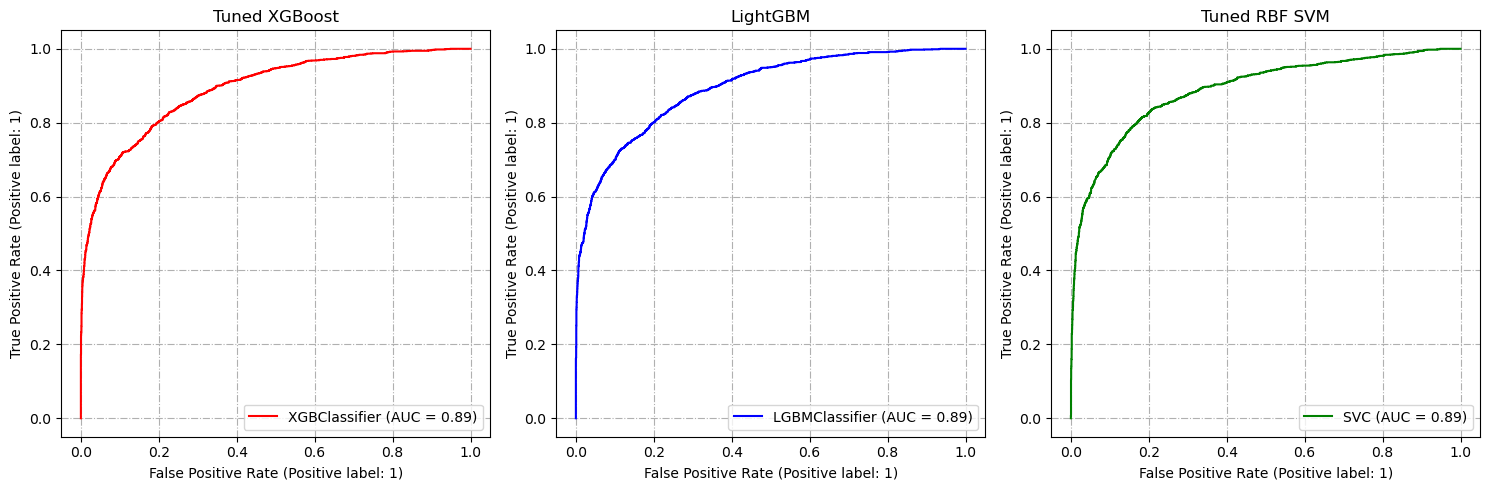

In [16]:
fig, axs = plt.subplots(1, 3,  figsize=(15,5))

axs[0].grid(linestyle="dashdot")
axs[0].set_title('Tuned XGBoost')
RocCurveDisplay.from_estimator(model_xgb, X_test, y_test, ax=axs[0], color='red')

axs[1].grid(linestyle="dashdot")
axs[1].set_title('LightGBM')
RocCurveDisplay.from_estimator(lgbm_model, X_test, y_test, ax=axs[1], color='blue')

axs[2].grid(linestyle="dashdot")
axs[2].set_title('Tuned RBF SVM')
RocCurveDisplay.from_estimator(kernel_svm, X_test, y_test, ax=axs[2], color='green')

plt.tight_layout()